# Call Center Staffing Simulation

## Purpose
Daily call volume prediction model to simulate staffing plans and quantify:
1. **Short calls** (understaffing)
2. **Over calls** (overstaffing/waste)
3. **Staffing stability** (variance reduction)
4. **Cost savings range** (ML vs baseline)

## Output
- Tables and figures ready for presentation slides
- CSV files for detailed analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from math import ceil
import warnings
warnings.filterwarnings('ignore')

# Font settings
plt.rcParams['font.family'] = 'MS Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.facecolor'] = 'white'

# Output directory
OUTPUT_DIR = Path('../output/sim_outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR.resolve()}")

Output directory: /kaggle/working/output/sim_outputs


---
## 1. Data Loading

In [2]:
def load_data():
    """
    Load prediction data from CSV.
    Auto-detect date, actual, and prediction columns.
    """
    # Search for prediction CSV
    candidate_paths = [
        '../output/call_slide/pred_model.csv',
        '../output/call_slide_extra/pred_model.csv',
        '../output/predictions.csv',
    ]
    
    df = None
    used_path = None
    
    for path in candidate_paths:
        if Path(path).exists():
            df = pd.read_csv(path)
            used_path = path
            break
    
    if df is None:
        raise FileNotFoundError("No prediction CSV found. Please provide pred_model.csv")
    
    print(f"Loaded: {used_path}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Auto-detect columns
    date_candidates = ['date', 'cdr_date', 'ds', 'datetime']
    actual_candidates = ['y_true', 'actual', 'actual_call_num', 'call_num', 'y', 'target']
    pred_candidates = ['y_pred', 'pred', 'pred_model', 'yhat', 'prediction']
    
    date_col = None
    actual_col = None
    pred_col = None
    
    for c in date_candidates:
        if c in df.columns:
            date_col = c
            break
    
    for c in actual_candidates:
        if c in df.columns:
            actual_col = c
            break
    
    for c in pred_candidates:
        if c in df.columns:
            pred_col = c
            break
    
    if date_col is None or actual_col is None:
        raise ValueError(f"Required columns not found. date_col={date_col}, actual_col={actual_col}")
    
    # Standardize column names
    df = df.rename(columns={
        date_col: 'date',
        actual_col: 'y_true',
    })
    
    if pred_col:
        df = df.rename(columns={pred_col: 'y_pred'})
    
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    print(f"\n[Adopted Columns]")
    print(f"  Date column:   {date_col} -> date")
    print(f"  Actual column: {actual_col} -> y_true")
    print(f"  Pred column:   {pred_col} -> y_pred" if pred_col else "  Pred column:   NOT FOUND")
    print(f"\nDate range: {df['date'].min()} ~ {df['date'].max()}")
    print(f"Records: {len(df)}")
    
    return df

# Load data
df = load_data()
df.head()

Loaded: ../output/call_slide/pred_model.csv
Shape: (33, 4)
Columns: ['cdr_date', 'actual_call_num', 'pred_model', 'pred_baseline']

[Adopted Columns]
  Date column:   cdr_date -> date
  Actual column: actual_call_num -> y_true
  Pred column:   pred_model -> y_pred

Date range: 2020-01-31 00:00:00 ~ 2020-03-27 00:00:00
Records: 33


,date,y_true,y_pred,pred_baseline
0,2020-01-31,125.0,147.565889,121.0
1,2020-02-04,116.0,154.445375,126.0
2,2020-02-05,153.0,150.508060,156.0
3,2020-02-06,135.0,130.660447,156.0
4,2020-02-07,147.0,148.996703,125.0


In [ ]:
# =============================================================================
# Correlation: call_num vs acc_get_cnt
# =============================================================================

# Load raw data
call_df = pd.read_csv('../input/regi_call_data_transform.csv')
acc_df = pd.read_csv('../input/regi_acc_get_data_transform.csv')

# Merge on date
call_df['cdr_date'] = pd.to_datetime(call_df['cdr_date'])
acc_df['cdr_date'] = pd.to_datetime(acc_df['cdr_date'])
corr_df = call_df.merge(acc_df, on='cdr_date', how='inner')

print(f"call_df: {len(call_df)} rows")
print(f"acc_df: {len(acc_df)} rows")
print(f"merged: {len(corr_df)} rows")
print(f"\nCorrelation: {corr_df['call_num'].corr(corr_df['acc_get_cnt']):.4f}")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Scatter plot
ax = axes[0]
ax.scatter(corr_df['acc_get_cnt'], corr_df['call_num'], alpha=0.5, s=20)
ax.set_xlabel('acc_get_cnt')
ax.set_ylabel('call_num')
ax.set_title(f'Scatter: call_num vs acc_get_cnt\n(r = {corr_df["call_num"].corr(corr_df["acc_get_cnt"]):.3f})')
ax.grid(alpha=0.3)

# Add regression line
z = np.polyfit(corr_df['acc_get_cnt'], corr_df['call_num'], 1)
p = np.poly1d(z)
x_line = np.linspace(corr_df['acc_get_cnt'].min(), corr_df['acc_get_cnt'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
ax.legend()

# 2. Time series (dual axis)
ax = axes[1]
ax2 = ax.twinx()
ax.plot(corr_df['cdr_date'], corr_df['call_num'], 'b-', alpha=0.7, label='call_num')
ax2.plot(corr_df['cdr_date'], corr_df['acc_get_cnt'], 'r-', alpha=0.7, label='acc_get_cnt')
ax.set_xlabel('Date')
ax.set_ylabel('call_num', color='blue')
ax2.set_ylabel('acc_get_cnt', color='red')
ax.set_title('Time Series: call_num & acc_get_cnt')
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')

# 3. Hexbin (density plot)
ax = axes[2]
hb = ax.hexbin(corr_df['acc_get_cnt'], corr_df['call_num'], gridsize=20, cmap='YlOrRd', mincnt=1)
ax.set_xlabel('acc_get_cnt')
ax.set_ylabel('call_num')
ax.set_title('Density: call_num vs acc_get_cnt')
plt.colorbar(hb, ax=ax, label='Count')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '0_correlation_call_acc.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR / '0_correlation_call_acc.png'}")

---
## 2. Build Baselines

In [3]:
def build_baselines(df):
    """
    Build baseline predictions (no-ML approach).
    All baselines use only past data (no leakage).
    """
    df = df.copy()
    
    # baseline_lag7: Same day last week
    # Note: Since we have weekday-only data, shift(5) = 1 week ago same weekday
    df['baseline_lag7'] = df['y_true'].shift(5)
    
    # baseline_ma7: 7-day moving average (shifted to avoid leakage)
    df['baseline_ma7'] = df['y_true'].shift(1).rolling(window=5, min_periods=1).mean()
    
    print("[Baselines Built]")
    print(f"  baseline_lag7: shift(5) (same weekday last week)")
    print(f"  baseline_ma7:  shift(1).rolling(5).mean()")
    print(f"  NaN counts - lag7: {df['baseline_lag7'].isna().sum()}, ma7: {df['baseline_ma7'].isna().sum()}")
    
    return df

df = build_baselines(df)
df.head(10)

[Baselines Built]
  baseline_lag7: shift(5) (same weekday last week)
  baseline_ma7:  shift(1).rolling(5).mean()
  NaN counts - lag7: 5, ma7: 1


,date,y_true,y_pred,pred_baseline,baseline_lag7,baseline_ma7
0,2020-01-31,125.0,147.565889,121.0,NaN,NaN
1,2020-02-04,116.0,154.445375,126.0,NaN,125.000000
2,2020-02-05,153.0,150.508060,156.0,NaN,120.500000
3,2020-02-06,135.0,130.660447,156.0,NaN,131.333333
4,2020-02-07,147.0,148.996703,125.0,NaN,132.250000
5,2020-02-11,0.0,88.733486,116.0,125.0,135.200000
6,2020-02-12,156.0,143.666842,153.0,116.0,110.200000
7,2020-02-13,139.0,137.429664,135.0,153.0,118.200000
8,2020-02-14,118.0,145.972379,147.0,135.0,115.400000
9,2020-02-18,109.0,138.043523,0.0,147.0,112.000000


---
## 3. Staffing Simulation

In [4]:
# =============================================================================
# Configuration Parameters
# =============================================================================

# Method 1: Direct cap assumption (calls per person per day)
CAP_LIST = [40, 60, 80]

# Buffer (alpha): Safety margin multiplier
BUFFER_LIST = [1.0, 1.1, 1.2]

# Method 2: AHT-based cap calculation
WORK_MINUTES_PER_DAY = 420  # 7 hours
OCCUPANCY_LIST = [0.80, 0.85, 0.90]
AHT_MINUTES_LIST = [5, 6, 8]

# Cost parameters (per call)
C_SHORT_LIST = [300, 600, 1000]  # Cost of understaffing per call
C_OVER_LIST = [0, 50, 100]        # Cost of overstaffing per call

# Representative scenario (for main visualizations)
REP_CAP = 60
REP_BUFFER = 1.1
REP_C_SHORT = 600
REP_C_OVER = 50

print("[Configuration]")
print(f"  CAP options: {CAP_LIST}")
print(f"  Buffer options: {BUFFER_LIST}")
print(f"  C_short options: {C_SHORT_LIST}")
print(f"  C_over options: {C_OVER_LIST}")
print(f"\n[Representative Scenario]")
print(f"  cap={REP_CAP}, buffer={REP_BUFFER}, c_short={REP_C_SHORT}, c_over={REP_C_OVER}")

[Configuration]
  CAP options: [40, 60, 80]
  Buffer options: [1.0, 1.1, 1.2]
  C_short options: [300, 600, 1000]
  C_over options: [0, 50, 100]

[Representative Scenario]
  cap=60, buffer=1.1, c_short=600, c_over=50


In [5]:
def calculate_cap_from_aht(work_minutes, occupancy, aht_minutes):
    """
    Method 2: Calculate cap from AHT and occupancy.
    cap = work_minutes * occupancy / aht_minutes
    """
    return work_minutes * occupancy / aht_minutes


def simulate_staffing(df, pred_col, cap, buffer, c_short, c_over):
    """
    Simulate staffing based on predictions.
    
    Parameters:
    -----------
    df : DataFrame with y_true and prediction column
    pred_col : str, name of prediction column to use
    cap : float, calls per person per day
    buffer : float, safety margin multiplier (e.g., 1.1 = 10% buffer)
    c_short : float, cost per understaffed call
    c_over : float, cost per overstaffed call
    
    Returns:
    --------
    DataFrame with simulation results
    """
    result = df[['date', 'y_true', pred_col]].copy()
    result = result.dropna(subset=[pred_col, 'y_true']).reset_index(drop=True)
    
    # Calculate required staff
    result['staff'] = result[pred_col].apply(lambda x: ceil(buffer * max(x, 0) / cap))
    
    # Calculate capacity
    result['capacity'] = result['staff'] * cap
    
    # Calculate short and over calls
    result['short_calls'] = np.maximum(0, result['y_true'] - result['capacity'])
    result['over_calls'] = np.maximum(0, result['capacity'] - result['y_true'])
    
    # Calculate daily cost
    result['daily_cost'] = c_short * result['short_calls'] + c_over * result['over_calls']
    
    return result


def evaluate(sim_result, pred_name):
    """
    Evaluate simulation results.
    """
    return {
        'pred_method': pred_name,
        'total_short_calls': sim_result['short_calls'].sum(),
        'total_over_calls': sim_result['over_calls'].sum(),
        'avg_staff': sim_result['staff'].mean(),
        'max_staff': sim_result['staff'].max(),
        'min_staff': sim_result['staff'].min(),
        'std_staff': sim_result['staff'].std(),
        'total_cost': sim_result['daily_cost'].sum(),
        'avg_daily_cost': sim_result['daily_cost'].mean(),
    }

print("Simulation functions defined.")

Simulation functions defined.


---
## 4. Run Simulations (All Scenarios)

In [6]:
def run_all_scenarios(df):
    """
    Run simulations for all parameter combinations.
    """
    results = []
    
    pred_methods = ['y_pred', 'baseline_lag7', 'baseline_ma7']
    
    for pred_col in pred_methods:
        if pred_col not in df.columns or df[pred_col].isna().all():
            print(f"  Skipping {pred_col} (not available)")
            continue
            
        for cap in CAP_LIST:
            for buffer in BUFFER_LIST:
                for c_short in C_SHORT_LIST:
                    for c_over in C_OVER_LIST:
                        sim = simulate_staffing(df, pred_col, cap, buffer, c_short, c_over)
                        metrics = evaluate(sim, pred_col)
                        metrics.update({
                            'cap': cap,
                            'buffer': buffer,
                            'c_short': c_short,
                            'c_over': c_over,
                            'method': 'direct_cap',
                        })
                        results.append(metrics)
    
    # Method 2: AHT-based scenarios
    for pred_col in pred_methods:
        if pred_col not in df.columns or df[pred_col].isna().all():
            continue
            
        for occupancy in OCCUPANCY_LIST:
            for aht in AHT_MINUTES_LIST:
                cap = calculate_cap_from_aht(WORK_MINUTES_PER_DAY, occupancy, aht)
                for buffer in BUFFER_LIST:
                    for c_short in [REP_C_SHORT]:  # Use representative cost
                        for c_over in [REP_C_OVER]:
                            sim = simulate_staffing(df, pred_col, cap, buffer, c_short, c_over)
                            metrics = evaluate(sim, pred_col)
                            metrics.update({
                                'cap': round(cap, 1),
                                'buffer': buffer,
                                'c_short': c_short,
                                'c_over': c_over,
                                'method': f'aht_based(occ={occupancy},aht={aht})',
                            })
                            results.append(metrics)
    
    return pd.DataFrame(results)

print("Running all scenarios...")
scenarios_df = run_all_scenarios(df)
print(f"Total scenarios: {len(scenarios_df)}")
scenarios_df.head(10)

Running all scenarios...
Total scenarios: 324


,pred_method,total_short_calls,total_over_calls,avg_staff,max_staff,min_staff,std_staff,total_cost,avg_daily_cost,cap,buffer,c_short,c_over,method
0,y_pred,35.0,1211.0,3.939394,5,2,0.428617,10500.0,318.181818,40.0,1.0,300,0,direct_cap
1,y_pred,35.0,1211.0,3.939394,5,2,0.428617,71050.0,2153.030303,40.0,1.0,300,50,direct_cap
2,y_pred,35.0,1211.0,3.939394,5,2,0.428617,131600.0,3987.878788,40.0,1.0,300,100,direct_cap
3,y_pred,35.0,1211.0,3.939394,5,2,0.428617,21000.0,636.363636,40.0,1.0,600,0,direct_cap
4,y_pred,35.0,1211.0,3.939394,5,2,0.428617,81550.0,2471.212121,40.0,1.0,600,50,direct_cap
5,y_pred,35.0,1211.0,3.939394,5,2,0.428617,142100.0,4306.060606,40.0,1.0,600,100,direct_cap
6,y_pred,35.0,1211.0,3.939394,5,2,0.428617,35000.0,1060.606061,40.0,1.0,1000,0,direct_cap
7,y_pred,35.0,1211.0,3.939394,5,2,0.428617,95550.0,2895.454545,40.0,1.0,1000,50,direct_cap
8,y_pred,35.0,1211.0,3.939394,5,2,0.428617,156100.0,4730.303030,40.0,1.0,1000,100,direct_cap
9,y_pred,35.0,1731.0,4.333333,5,3,0.595119,10500.0,318.181818,40.0,1.1,300,0,direct_cap


In [7]:
# =============================================================================
# Compare ML vs Baseline (Improvement Calculation)
# =============================================================================

def calculate_improvements(scenarios_df):
    """
    Calculate improvement rates: ML vs baseline.
    """
    # Group by scenario parameters
    group_cols = ['cap', 'buffer', 'c_short', 'c_over', 'method']
    
    improvements = []
    
    for name, group in scenarios_df.groupby(group_cols):
        ml_row = group[group['pred_method'] == 'y_pred']
        lag7_row = group[group['pred_method'] == 'baseline_lag7']
        ma7_row = group[group['pred_method'] == 'baseline_ma7']
        
        if ml_row.empty:
            continue
        
        ml = ml_row.iloc[0]
        
        row = {
            'cap': name[0],
            'buffer': name[1],
            'c_short': name[2],
            'c_over': name[3],
            'method': name[4],
            'ml_cost': ml['total_cost'],
            'ml_short': ml['total_short_calls'],
            'ml_over': ml['total_over_calls'],
            'ml_std_staff': ml['std_staff'],
        }
        
        if not lag7_row.empty:
            lag7 = lag7_row.iloc[0]
            row['lag7_cost'] = lag7['total_cost']
            row['lag7_short'] = lag7['total_short_calls']
            row['lag7_over'] = lag7['total_over_calls']
            row['lag7_std_staff'] = lag7['std_staff']
            
            # Improvement rates
            if lag7['total_cost'] > 0:
                row['cost_improve_vs_lag7_%'] = (lag7['total_cost'] - ml['total_cost']) / lag7['total_cost'] * 100
            if lag7['total_short_calls'] > 0:
                row['short_improve_vs_lag7_%'] = (lag7['total_short_calls'] - ml['total_short_calls']) / lag7['total_short_calls'] * 100
        
        if not ma7_row.empty:
            ma7 = ma7_row.iloc[0]
            row['ma7_cost'] = ma7['total_cost']
            row['ma7_short'] = ma7['total_short_calls']
            row['ma7_over'] = ma7['total_over_calls']
            row['ma7_std_staff'] = ma7['std_staff']
            
            if ma7['total_cost'] > 0:
                row['cost_improve_vs_ma7_%'] = (ma7['total_cost'] - ml['total_cost']) / ma7['total_cost'] * 100
            if ma7['total_short_calls'] > 0:
                row['short_improve_vs_ma7_%'] = (ma7['total_short_calls'] - ml['total_short_calls']) / ma7['total_short_calls'] * 100
        
        improvements.append(row)
    
    return pd.DataFrame(improvements)

improvements_df = calculate_improvements(scenarios_df)
print(f"Improvement scenarios: {len(improvements_df)}")
improvements_df.head(10)

Improvement scenarios: 108


,cap,buffer,c_short,c_over,method,ml_cost,ml_short,ml_over,ml_std_staff,lag7_cost,...,lag7_over,lag7_std_staff,cost_improve_vs_lag7_%,short_improve_vs_lag7_%,ma7_cost,ma7_short,ma7_over,ma7_std_staff,cost_improve_vs_ma7_%,short_improve_vs_ma7_%
0,40.0,1.0,300,0,direct_cap,10500.0,35.0,1211.0,0.428617,112500.0,...,867.0,0.878912,90.666667,90.666667,62700.0,209.0,830.0,0.507007,83.253589,83.253589
1,40.0,1.0,300,50,direct_cap,71050.0,35.0,1211.0,0.428617,155850.0,...,867.0,0.878912,54.411293,90.666667,104200.0,209.0,830.0,0.507007,31.813820,83.253589
2,40.0,1.0,300,100,direct_cap,131600.0,35.0,1211.0,0.428617,199200.0,...,867.0,0.878912,33.935743,90.666667,145700.0,209.0,830.0,0.507007,9.677419,83.253589
3,40.0,1.0,600,0,direct_cap,21000.0,35.0,1211.0,0.428617,225000.0,...,867.0,0.878912,90.666667,90.666667,125400.0,209.0,830.0,0.507007,83.253589,83.253589
4,40.0,1.0,600,50,direct_cap,81550.0,35.0,1211.0,0.428617,268350.0,...,867.0,0.878912,69.610583,90.666667,166900.0,209.0,830.0,0.507007,51.138406,83.253589
5,40.0,1.0,600,100,direct_cap,142100.0,35.0,1211.0,0.428617,311700.0,...,867.0,0.878912,54.411293,90.666667,208400.0,209.0,830.0,0.507007,31.813820,83.253589
6,40.0,1.0,1000,0,direct_cap,35000.0,35.0,1211.0,0.428617,375000.0,...,867.0,0.878912,90.666667,90.666667,209000.0,209.0,830.0,0.507007,83.253589,83.253589
7,40.0,1.0,1000,50,direct_cap,95550.0,35.0,1211.0,0.428617,418350.0,...,867.0,0.878912,77.160272,90.666667,250500.0,209.0,830.0,0.507007,61.856287,83.253589
8,40.0,1.0,1000,100,direct_cap,156100.0,35.0,1211.0,0.428617,461700.0,...,867.0,0.878912,66.190167,90.666667,292000.0,209.0,830.0,0.507007,46.541096,83.253589
9,40.0,1.1,300,0,direct_cap,10500.0,35.0,1731.0,0.595119,65100.0,...,1389.0,1.070899,83.870968,83.870968,24600.0,82.0,1183.0,0.465547,57.317073,57.317073


---
## 5. Representative Scenario Analysis

In [8]:
# =============================================================================
# Run Representative Scenario
# =============================================================================

print("="*60)
print("REPRESENTATIVE SCENARIO")
print("="*60)
print(f"cap={REP_CAP}, buffer={REP_BUFFER}, c_short={REP_C_SHORT}, c_over={REP_C_OVER}")
print("="*60)

# ML model
sim_ml = simulate_staffing(df, 'y_pred', REP_CAP, REP_BUFFER, REP_C_SHORT, REP_C_OVER)
sim_ml['method'] = 'ML Model'

# Baseline lag7
sim_lag7 = simulate_staffing(df, 'baseline_lag7', REP_CAP, REP_BUFFER, REP_C_SHORT, REP_C_OVER)
sim_lag7['method'] = 'Baseline (Lag7)'

# Baseline ma7
sim_ma7 = simulate_staffing(df, 'baseline_ma7', REP_CAP, REP_BUFFER, REP_C_SHORT, REP_C_OVER)
sim_ma7['method'] = 'Baseline (MA7)'

# Evaluation
eval_ml = evaluate(sim_ml, 'ML Model')
eval_lag7 = evaluate(sim_lag7, 'Baseline (Lag7)')
eval_ma7 = evaluate(sim_ma7, 'Baseline (MA7)')

rep_summary = pd.DataFrame([eval_ml, eval_lag7, eval_ma7])
print("\n[Representative Scenario Results]")
print(rep_summary.to_string(index=False))

REPRESENTATIVE SCENARIO
cap=60, buffer=1.1, c_short=600, c_over=50

[Representative Scenario Results]
    pred_method  total_short_calls  total_over_calls  avg_staff  max_staff  min_staff  std_staff  total_cost  avg_daily_cost
       ML Model                7.0            1863.0   2.969697          4          2   0.304636     97350.0     2950.000000
Baseline (Lag7)              209.0            1541.0   2.785714          4          0   0.686221    202450.0     7230.357143
 Baseline (MA7)               62.0            1623.0   2.843750          3          2   0.368902    118350.0     3698.437500


In [9]:
# =============================================================================
# Calculate Improvement Summary
# =============================================================================

print("\n" + "="*60)
print("IMPROVEMENT SUMMARY (ML vs Baselines)")
print("="*60)

# vs Lag7
if eval_lag7['total_cost'] > 0:
    cost_improve_lag7 = (eval_lag7['total_cost'] - eval_ml['total_cost']) / eval_lag7['total_cost'] * 100
    short_improve_lag7 = (eval_lag7['total_short_calls'] - eval_ml['total_short_calls']) / max(eval_lag7['total_short_calls'], 1) * 100
    over_improve_lag7 = (eval_lag7['total_over_calls'] - eval_ml['total_over_calls']) / max(eval_lag7['total_over_calls'], 1) * 100
    std_improve_lag7 = (eval_lag7['std_staff'] - eval_ml['std_staff']) / max(eval_lag7['std_staff'], 0.01) * 100
    
    print(f"\n[vs Baseline Lag7]")
    print(f"  Cost reduction:     {cost_improve_lag7:+.1f}%")
    print(f"  Short calls change: {short_improve_lag7:+.1f}%")
    print(f"  Over calls change:  {over_improve_lag7:+.1f}%")
    print(f"  Staff stability:    {std_improve_lag7:+.1f}% (std reduction)")

# vs MA7
if eval_ma7['total_cost'] > 0:
    cost_improve_ma7 = (eval_ma7['total_cost'] - eval_ml['total_cost']) / eval_ma7['total_cost'] * 100
    short_improve_ma7 = (eval_ma7['total_short_calls'] - eval_ml['total_short_calls']) / max(eval_ma7['total_short_calls'], 1) * 100
    over_improve_ma7 = (eval_ma7['total_over_calls'] - eval_ml['total_over_calls']) / max(eval_ma7['total_over_calls'], 1) * 100
    std_improve_ma7 = (eval_ma7['std_staff'] - eval_ml['std_staff']) / max(eval_ma7['std_staff'], 0.01) * 100
    
    print(f"\n[vs Baseline MA7]")
    print(f"  Cost reduction:     {cost_improve_ma7:+.1f}%")
    print(f"  Short calls change: {short_improve_ma7:+.1f}%")
    print(f"  Over calls change:  {over_improve_ma7:+.1f}%")
    print(f"  Staff stability:    {std_improve_ma7:+.1f}% (std reduction)")

print(f"\n[Absolute Values]")
print(f"  ML total cost:      {eval_ml['total_cost']:,.0f} yen")
print(f"  Lag7 total cost:    {eval_lag7['total_cost']:,.0f} yen")
print(f"  MA7 total cost:     {eval_ma7['total_cost']:,.0f} yen")
print(f"  Cost savings (Lag7): {eval_lag7['total_cost'] - eval_ml['total_cost']:,.0f} yen")
print(f"  Cost savings (MA7):  {eval_ma7['total_cost'] - eval_ml['total_cost']:,.0f} yen")


IMPROVEMENT SUMMARY (ML vs Baselines)

[vs Baseline Lag7]
  Cost reduction:     +51.9%
  Short calls change: +96.7%
  Over calls change:  -20.9%
  Staff stability:    +55.6% (std reduction)

[vs Baseline MA7]
  Cost reduction:     +17.7%
  Short calls change: +88.7%
  Over calls change:  -14.8%
  Staff stability:    +17.4% (std reduction)

[Absolute Values]
  ML total cost:      97,350 yen
  Lag7 total cost:    202,450 yen
  MA7 total cost:     118,350 yen
  Cost savings (Lag7): 105,100 yen
  Cost savings (MA7):  21,000 yen


---
## 6. Visualizations

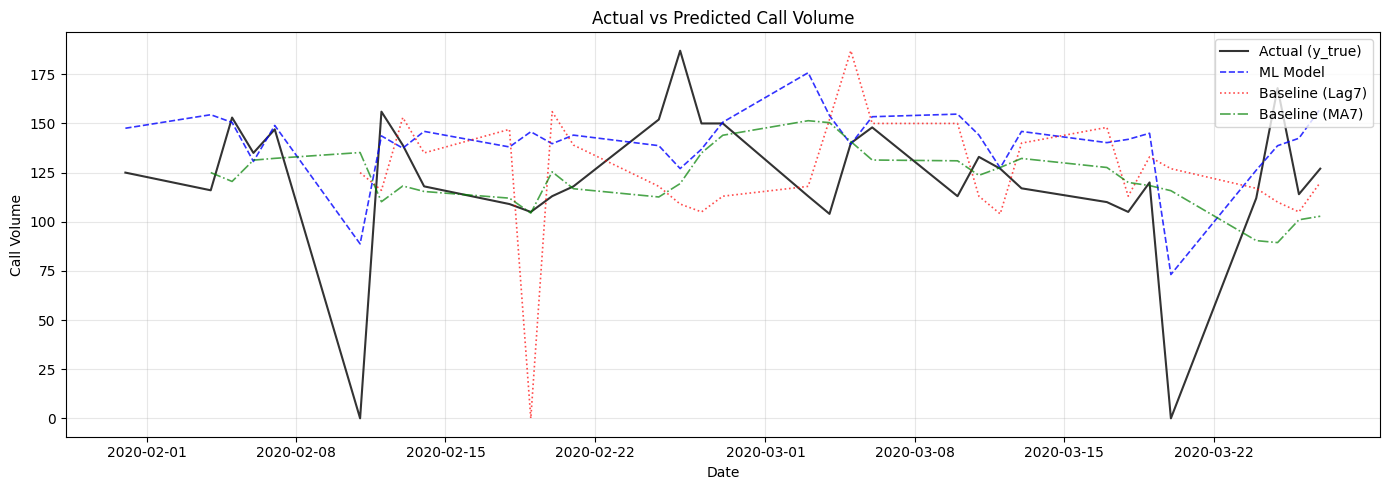

Saved: ../output/sim_outputs/1_timeseries_predictions.png


In [10]:
# =============================================================================
# Plot 1: Time Series - Actual vs Predictions
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(sim_ml['date'], sim_ml['y_true'], 'k-', linewidth=1.5, label='Actual (y_true)', alpha=0.8)
ax.plot(sim_ml['date'], sim_ml['y_pred'], 'b--', linewidth=1.2, label='ML Model', alpha=0.8)
ax.plot(sim_lag7['date'], sim_lag7['baseline_lag7'], 'r:', linewidth=1.2, label='Baseline (Lag7)', alpha=0.7)
ax.plot(sim_ma7['date'], sim_ma7['baseline_ma7'], 'g-.', linewidth=1.2, label='Baseline (MA7)', alpha=0.7)

ax.set_xlabel('Date')
ax.set_ylabel('Call Volume')
ax.set_title('Actual vs Predicted Call Volume')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '1_timeseries_predictions.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR / '1_timeseries_predictions.png'}")

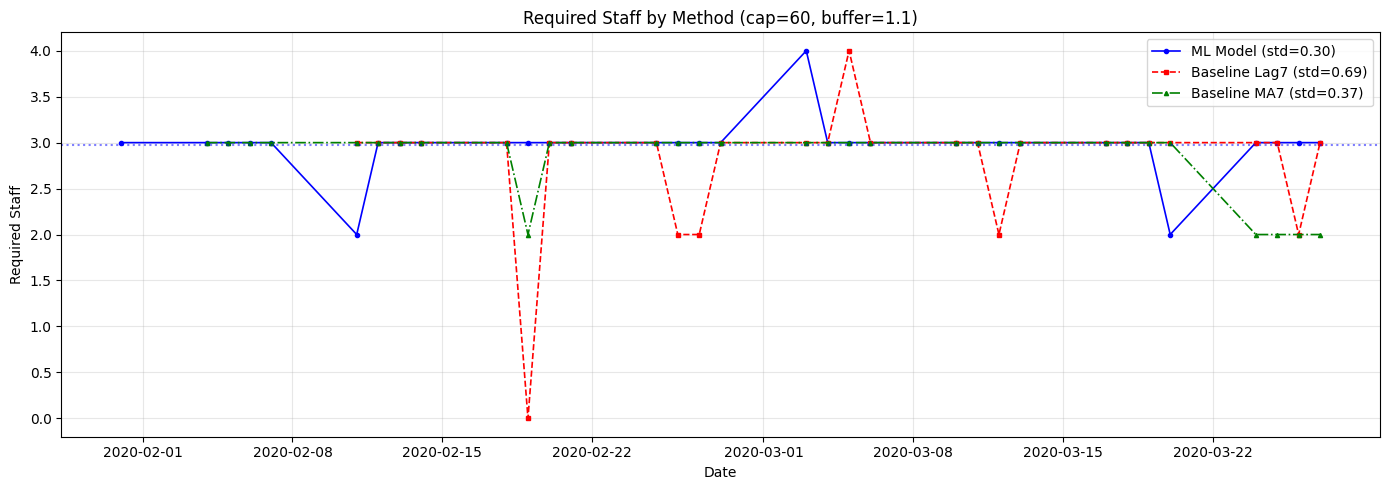

Saved: ../output/sim_outputs/2_timeseries_staff.png


In [11]:
# =============================================================================
# Plot 2: Required Staff (ML vs Baseline)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(sim_ml['date'], sim_ml['staff'], 'b-', linewidth=1.2, label=f'ML Model (std={eval_ml["std_staff"]:.2f})', marker='o', markersize=3)
ax.plot(sim_lag7['date'], sim_lag7['staff'], 'r--', linewidth=1.2, label=f'Baseline Lag7 (std={eval_lag7["std_staff"]:.2f})', marker='s', markersize=3)
ax.plot(sim_ma7['date'], sim_ma7['staff'], 'g-.', linewidth=1.2, label=f'Baseline MA7 (std={eval_ma7["std_staff"]:.2f})', marker='^', markersize=3)

ax.axhline(eval_ml['avg_staff'], color='blue', linestyle=':', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Required Staff')
ax.set_title(f'Required Staff by Method (cap={REP_CAP}, buffer={REP_BUFFER})')
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '2_timeseries_staff.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR / '2_timeseries_staff.png'}")

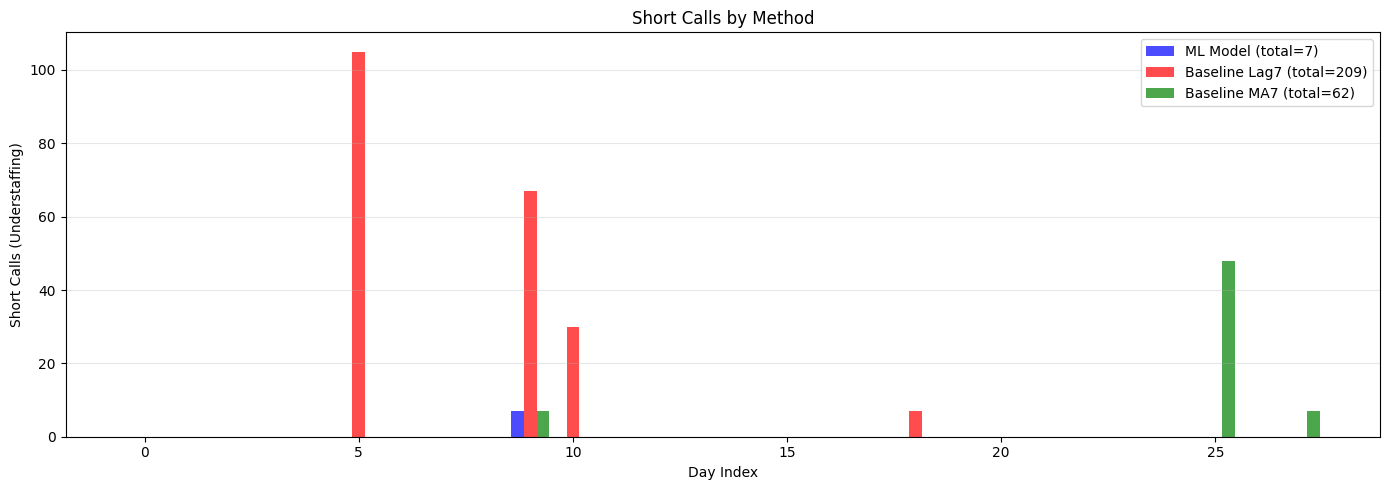

Saved: ../output/sim_outputs/3_timeseries_short_calls.png


In [12]:
# =============================================================================
# Plot 3: Short Calls (Understaffing)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 5))

# Align all simulations to common dates
common_dates = set(sim_ml['date']) & set(sim_lag7['date']) & set(sim_ma7['date'])
sim_ml_aligned = sim_ml[sim_ml['date'].isin(common_dates)].reset_index(drop=True)
sim_lag7_aligned = sim_lag7[sim_lag7['date'].isin(common_dates)].reset_index(drop=True)
sim_ma7_aligned = sim_ma7[sim_ma7['date'].isin(common_dates)].reset_index(drop=True)

width = 0.3
x = np.arange(len(sim_ml_aligned))

ax.bar(x - width, sim_ml_aligned['short_calls'], width, label=f'ML Model (total={eval_ml["total_short_calls"]:.0f})', color='blue', alpha=0.7)
ax.bar(x, sim_lag7_aligned['short_calls'], width, label=f'Baseline Lag7 (total={eval_lag7["total_short_calls"]:.0f})', color='red', alpha=0.7)
ax.bar(x + width, sim_ma7_aligned['short_calls'], width, label=f'Baseline MA7 (total={eval_ma7["total_short_calls"]:.0f})', color='green', alpha=0.7)

ax.set_xlabel('Day Index')
ax.set_ylabel('Short Calls (Understaffing)')
ax.set_title('Short Calls by Method')
ax.legend(loc='upper right')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '3_timeseries_short_calls.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR / '3_timeseries_short_calls.png'}")

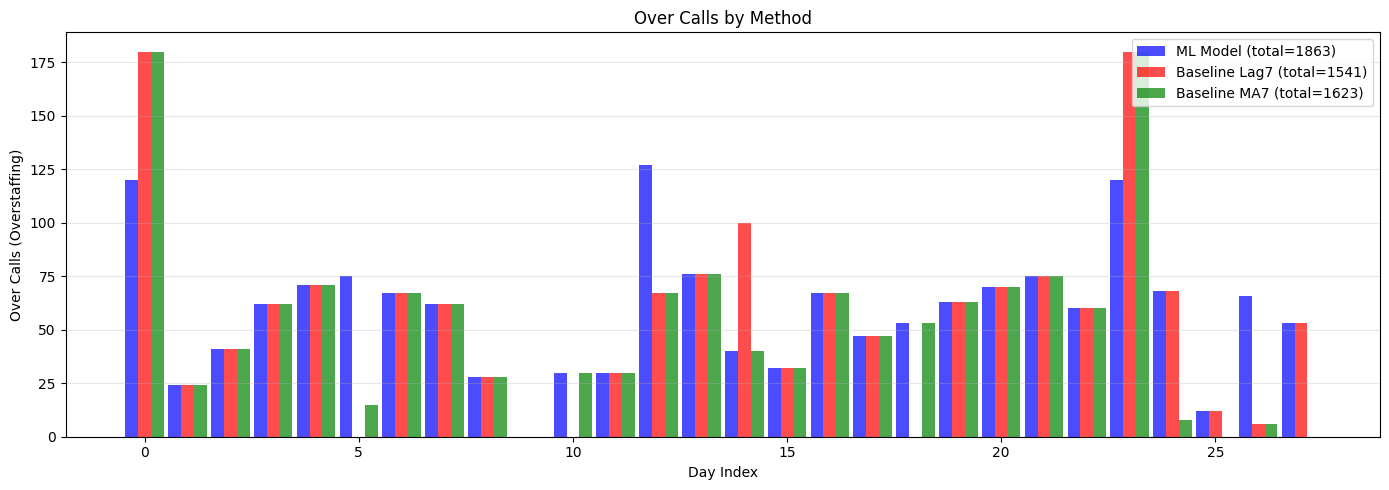

Saved: ../output/sim_outputs/4_timeseries_over_calls.png


In [13]:
# =============================================================================
# Plot 4: Over Calls (Overstaffing/Waste)
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 5))

# Use aligned dataframes from previous cell
ax.bar(x - width, sim_ml_aligned['over_calls'], width, label=f'ML Model (total={eval_ml["total_over_calls"]:.0f})', color='blue', alpha=0.7)
ax.bar(x, sim_lag7_aligned['over_calls'], width, label=f'Baseline Lag7 (total={eval_lag7["total_over_calls"]:.0f})', color='red', alpha=0.7)
ax.bar(x + width, sim_ma7_aligned['over_calls'], width, label=f'Baseline MA7 (total={eval_ma7["total_over_calls"]:.0f})', color='green', alpha=0.7)

ax.set_xlabel('Day Index')
ax.set_ylabel('Over Calls (Overstaffing)')
ax.set_title('Over Calls by Method')
ax.legend(loc='upper right')
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '4_timeseries_over_calls.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR / '4_timeseries_over_calls.png'}")

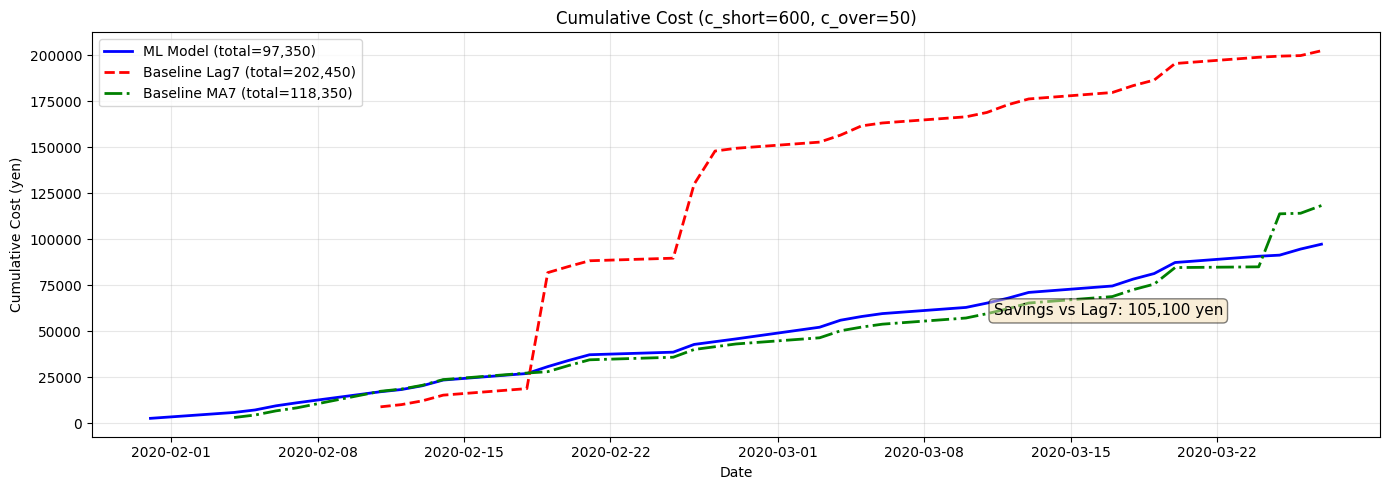

Saved: ../output/sim_outputs/5_cumulative_cost.png


In [14]:
# =============================================================================
# Plot 5: Cumulative Cost
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(sim_ml['date'], sim_ml['daily_cost'].cumsum(), 'b-', linewidth=2, label=f'ML Model (total={eval_ml["total_cost"]:,.0f})')
ax.plot(sim_lag7['date'], sim_lag7['daily_cost'].cumsum(), 'r--', linewidth=2, label=f'Baseline Lag7 (total={eval_lag7["total_cost"]:,.0f})')
ax.plot(sim_ma7['date'], sim_ma7['daily_cost'].cumsum(), 'g-.', linewidth=2, label=f'Baseline MA7 (total={eval_ma7["total_cost"]:,.0f})')

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Cost (yen)')
ax.set_title(f'Cumulative Cost (c_short={REP_C_SHORT}, c_over={REP_C_OVER})')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

# Add savings annotation
savings_lag7 = eval_lag7['total_cost'] - eval_ml['total_cost']
ax.annotate(f'Savings vs Lag7: {savings_lag7:,.0f} yen', 
            xy=(0.7, 0.3), xycoords='axes fraction',
            fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '5_cumulative_cost.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR / '5_cumulative_cost.png'}")

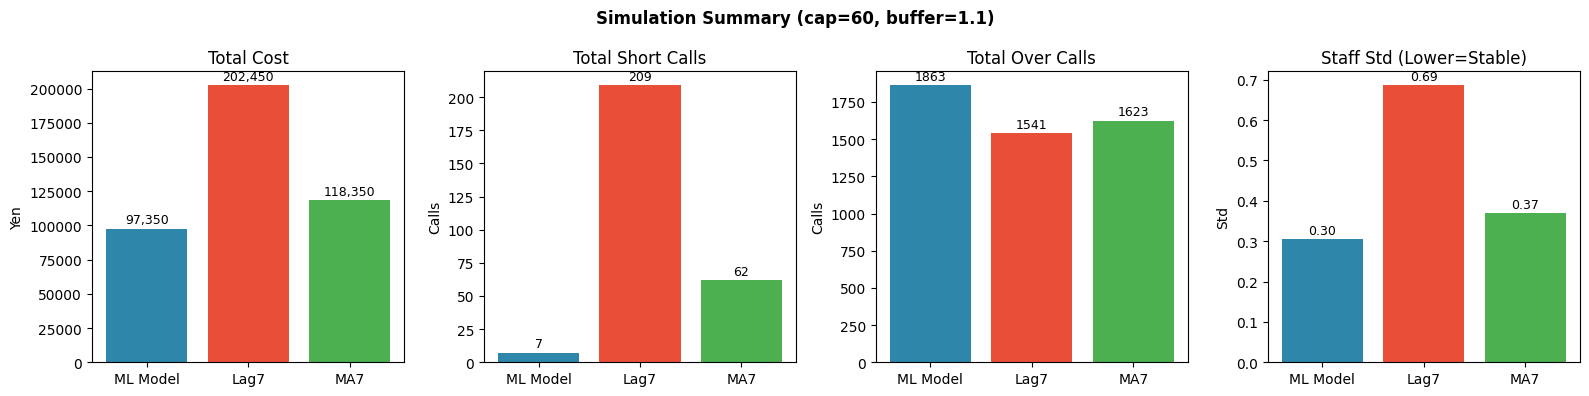

Saved: ../output/sim_outputs/6_summary_comparison.png


In [15]:
# =============================================================================
# Plot 6: Summary Bar Chart (for slides)
# =============================================================================

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

methods = ['ML Model', 'Lag7', 'MA7']
colors = ['#2E86AB', '#E94F37', '#4CAF50']

# Total Cost
values = [eval_ml['total_cost'], eval_lag7['total_cost'], eval_ma7['total_cost']]
axes[0].bar(methods, values, color=colors)
axes[0].set_title('Total Cost')
axes[0].set_ylabel('Yen')
for i, v in enumerate(values):
    axes[0].text(i, v + max(values)*0.02, f'{v:,.0f}', ha='center', fontsize=9)

# Short Calls
values = [eval_ml['total_short_calls'], eval_lag7['total_short_calls'], eval_ma7['total_short_calls']]
axes[1].bar(methods, values, color=colors)
axes[1].set_title('Total Short Calls')
axes[1].set_ylabel('Calls')
for i, v in enumerate(values):
    axes[1].text(i, v + max(values)*0.02, f'{v:.0f}', ha='center', fontsize=9)

# Over Calls
values = [eval_ml['total_over_calls'], eval_lag7['total_over_calls'], eval_ma7['total_over_calls']]
axes[2].bar(methods, values, color=colors)
axes[2].set_title('Total Over Calls')
axes[2].set_ylabel('Calls')
for i, v in enumerate(values):
    axes[2].text(i, v + max(values)*0.02, f'{v:.0f}', ha='center', fontsize=9)

# Staff Std (Stability)
values = [eval_ml['std_staff'], eval_lag7['std_staff'], eval_ma7['std_staff']]
axes[3].bar(methods, values, color=colors)
axes[3].set_title('Staff Std (Lower=Stable)')
axes[3].set_ylabel('Std')
for i, v in enumerate(values):
    axes[3].text(i, v + max(values)*0.02, f'{v:.2f}', ha='center', fontsize=9)

plt.suptitle(f'Simulation Summary (cap={REP_CAP}, buffer={REP_BUFFER})', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / '6_summary_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR / '6_summary_comparison.png'}")

---
## 7. Sensitivity Analysis

In [16]:
# =============================================================================
# Sensitivity Analysis Table
# =============================================================================

# Filter for direct_cap method and representative cost
sensitivity_df = scenarios_df[
    (scenarios_df['method'] == 'direct_cap') & 
    (scenarios_df['c_short'] == REP_C_SHORT) & 
    (scenarios_df['c_over'] == REP_C_OVER)
].copy()

# Pivot table: cap x buffer x method
pivot_cost = sensitivity_df.pivot_table(
    index=['cap', 'buffer'],
    columns='pred_method',
    values='total_cost',
    aggfunc='first'
).reset_index()

# Calculate improvement
if 'y_pred' in pivot_cost.columns and 'baseline_lag7' in pivot_cost.columns:
    pivot_cost['ML vs Lag7 (%)'] = ((pivot_cost['baseline_lag7'] - pivot_cost['y_pred']) / pivot_cost['baseline_lag7'] * 100).round(1)

print("[Sensitivity Analysis: Cost by cap and buffer]")
print(pivot_cost.to_string(index=False))

[Sensitivity Analysis: Cost by cap and buffer]
 cap  buffer  baseline_lag7  baseline_ma7   y_pred  ML vs Lag7 (%)
40.0     1.0       268350.0      166900.0  81550.0            69.6
40.0     1.1       199650.0      108350.0 107550.0            46.1
40.0     1.2       163600.0      117800.0 132350.0            19.1
60.0     1.0       283350.0      183900.0  94350.0            66.7
60.0     1.1       202450.0      118350.0  97350.0            51.9
60.0     1.2       160400.0      128800.0 118350.0            26.2
80.0     1.0       143600.0       83800.0  85550.0            40.4
80.0     1.1       171600.0       91800.0 137550.0            19.8
80.0     1.2       183600.0      107800.0 188350.0            -2.6


In [17]:
# =============================================================================
# Cost Sensitivity by c_short
# =============================================================================

sensitivity_cshort = scenarios_df[
    (scenarios_df['method'] == 'direct_cap') & 
    (scenarios_df['cap'] == REP_CAP) & 
    (scenarios_df['buffer'] == REP_BUFFER) &
    (scenarios_df['c_over'] == REP_C_OVER)
].copy()

pivot_cshort = sensitivity_cshort.pivot_table(
    index='c_short',
    columns='pred_method',
    values='total_cost',
    aggfunc='first'
).reset_index()

if 'y_pred' in pivot_cshort.columns and 'baseline_lag7' in pivot_cshort.columns:
    pivot_cshort['Savings (yen)'] = (pivot_cshort['baseline_lag7'] - pivot_cshort['y_pred']).round(0)
    pivot_cshort['Savings (%)'] = ((pivot_cshort['baseline_lag7'] - pivot_cshort['y_pred']) / pivot_cshort['baseline_lag7'] * 100).round(1)

print("\n[Cost Sensitivity by c_short (cost per understaffed call)]")
print(pivot_cshort.to_string(index=False))


[Cost Sensitivity by c_short (cost per understaffed call)]
 c_short  baseline_lag7  baseline_ma7   y_pred  Savings (yen)  Savings (%)
     300       139750.0       99750.0  95250.0        44500.0         31.8
     600       202450.0      118350.0  97350.0       105100.0         51.9
    1000       286050.0      143150.0 100150.0       185900.0         65.0


---
## 8. Save Outputs

In [18]:
# =============================================================================
# Save Daily Detail CSV
# =============================================================================

# Align all simulations to common dates
common_dates = set(sim_ml['date']) & set(sim_lag7['date']) & set(sim_ma7['date'])
sim_ml_common = sim_ml[sim_ml['date'].isin(common_dates)].sort_values('date').reset_index(drop=True)
sim_lag7_common = sim_lag7[sim_lag7['date'].isin(common_dates)].sort_values('date').reset_index(drop=True)
sim_ma7_common = sim_ma7[sim_ma7['date'].isin(common_dates)].sort_values('date').reset_index(drop=True)

# Merge ML and baseline results
daily_detail = sim_ml_common[['date', 'y_true', 'y_pred', 'staff', 'capacity', 'short_calls', 'over_calls', 'daily_cost']].copy()
daily_detail.columns = ['date', 'y_true', 'y_pred_ml', 'staff_ml', 'capacity_ml', 'short_ml', 'over_ml', 'cost_ml']

daily_detail['y_pred_lag7'] = sim_lag7_common['baseline_lag7'].values
daily_detail['staff_lag7'] = sim_lag7_common['staff'].values
daily_detail['short_lag7'] = sim_lag7_common['short_calls'].values
daily_detail['over_lag7'] = sim_lag7_common['over_calls'].values
daily_detail['cost_lag7'] = sim_lag7_common['daily_cost'].values

daily_detail['y_pred_ma7'] = sim_ma7_common['baseline_ma7'].values
daily_detail['staff_ma7'] = sim_ma7_common['staff'].values
daily_detail['short_ma7'] = sim_ma7_common['short_calls'].values
daily_detail['over_ma7'] = sim_ma7_common['over_calls'].values
daily_detail['cost_ma7'] = sim_ma7_common['daily_cost'].values

daily_detail.to_csv(OUTPUT_DIR / 'simulation_daily_detail.csv', index=False)
print(f"Saved: {OUTPUT_DIR / 'simulation_daily_detail.csv'}")
print(f"Records: {len(daily_detail)} (common dates only)")
daily_detail.head()

Saved: ../output/sim_outputs/simulation_daily_detail.csv
Records: 28 (common dates only)


,date,y_true,y_pred_ml,staff_ml,capacity_ml,short_ml,over_ml,cost_ml,y_pred_lag7,staff_lag7,short_lag7,over_lag7,cost_lag7,y_pred_ma7,staff_ma7,short_ma7,over_ma7,cost_ma7
0,2020-02-11,0.0,88.733486,2,120,0.0,120.0,6000.0,125.0,3,0.0,180.0,9000.0,135.2,3,0.0,180.0,9000.0
1,2020-02-12,156.0,143.666842,3,180,0.0,24.0,1200.0,116.0,3,0.0,24.0,1200.0,110.2,3,0.0,24.0,1200.0
2,2020-02-13,139.0,137.429664,3,180,0.0,41.0,2050.0,153.0,3,0.0,41.0,2050.0,118.2,3,0.0,41.0,2050.0
3,2020-02-14,118.0,145.972379,3,180,0.0,62.0,3100.0,135.0,3,0.0,62.0,3100.0,115.4,3,0.0,62.0,3100.0
4,2020-02-18,109.0,138.043523,3,180,0.0,71.0,3550.0,147.0,3,0.0,71.0,3550.0,112.0,3,0.0,71.0,3550.0


In [19]:
# =============================================================================
# Save Scenarios Summary CSV
# =============================================================================

scenarios_df.to_csv(OUTPUT_DIR / 'simulation_scenarios_summary.csv', index=False)
print(f"Saved: {OUTPUT_DIR / 'simulation_scenarios_summary.csv'}")
print(f"Total scenarios: {len(scenarios_df)}")

Saved: ../output/sim_outputs/simulation_scenarios_summary.csv
Total scenarios: 324


In [20]:
# =============================================================================
# Save Representative Summary TXT
# =============================================================================

summary_text = f"""
================================================================================
CALL CENTER STAFFING SIMULATION - REPRESENTATIVE SCENARIO SUMMARY
================================================================================

[Parameters]
- cap (calls/person/day): {REP_CAP}
- buffer (safety margin):  {REP_BUFFER} ({(REP_BUFFER-1)*100:.0f}% extra)
- c_short (cost/understaffed call): {REP_C_SHORT} yen
- c_over (cost/overstaffed call):   {REP_C_OVER} yen
- Period: {daily_detail['date'].min().strftime('%Y-%m-%d')} ~ {daily_detail['date'].max().strftime('%Y-%m-%d')}
- Days: {len(daily_detail)}

================================================================================
[Results: ML Model]
================================================================================
- Total Cost:        {eval_ml['total_cost']:>12,.0f} yen
- Total Short Calls: {eval_ml['total_short_calls']:>12,.0f} calls
- Total Over Calls:  {eval_ml['total_over_calls']:>12,.0f} calls
- Avg Staff:         {eval_ml['avg_staff']:>12.1f} persons
- Staff Std:         {eval_ml['std_staff']:>12.2f} (stability)

================================================================================
[Results: Baseline Lag7 (same weekday last week)]
================================================================================
- Total Cost:        {eval_lag7['total_cost']:>12,.0f} yen
- Total Short Calls: {eval_lag7['total_short_calls']:>12,.0f} calls
- Total Over Calls:  {eval_lag7['total_over_calls']:>12,.0f} calls
- Avg Staff:         {eval_lag7['avg_staff']:>12.1f} persons
- Staff Std:         {eval_lag7['std_staff']:>12.2f} (stability)

================================================================================
[Improvement: ML vs Baseline Lag7]
================================================================================
- Cost Reduction:    {cost_improve_lag7:>+10.1f}%  (Savings: {eval_lag7['total_cost'] - eval_ml['total_cost']:,.0f} yen)
- Short Calls:       {short_improve_lag7:>+10.1f}%
- Over Calls:        {over_improve_lag7:>+10.1f}%
- Staff Stability:   {std_improve_lag7:>+10.1f}% (std reduction)

================================================================================
[Key Findings for Slides]
================================================================================
1. Cost Savings: ML model reduces total cost by {abs(cost_improve_lag7):.1f}% compared to baseline
2. Understaffing: Short calls {'reduced' if short_improve_lag7 > 0 else 'increased'} by {abs(short_improve_lag7):.1f}%
3. Stability: Staff requirement variability {'reduced' if std_improve_lag7 > 0 else 'increased'} by {abs(std_improve_lag7):.1f}%
4. Monthly Savings (estimated): {(eval_lag7['total_cost'] - eval_ml['total_cost']) / len(daily_detail) * 20:,.0f} yen/month (20 working days)

================================================================================
[Output Files]
================================================================================
- simulation_daily_detail.csv: Daily breakdown of all metrics
- simulation_scenarios_summary.csv: All scenario combinations
- 1_timeseries_predictions.png: Actual vs Predicted
- 2_timeseries_staff.png: Required staff comparison
- 3_timeseries_short_calls.png: Understaffing events
- 4_timeseries_over_calls.png: Overstaffing events
- 5_cumulative_cost.png: Cumulative cost comparison
- 6_summary_comparison.png: Summary bar charts

================================================================================
"""

with open(OUTPUT_DIR / 'representative_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary_text)

print(f"Saved: {OUTPUT_DIR / 'representative_summary.txt'}")
print(summary_text)

Saved: ../output/sim_outputs/representative_summary.txt

CALL CENTER STAFFING SIMULATION - REPRESENTATIVE SCENARIO SUMMARY

[Parameters]
- cap (calls/person/day): 60
- buffer (safety margin):  1.1 (10% extra)
- c_short (cost/understaffed call): 600 yen
- c_over (cost/overstaffed call):   50 yen
- Period: 2020-02-11 ~ 2020-03-27
- Days: 28

[Results: ML Model]
- Total Cost:              97,350 yen
- Total Short Calls:            7 calls
- Total Over Calls:         1,863 calls
- Avg Staff:                  3.0 persons
- Staff Std:                 0.30 (stability)

[Results: Baseline Lag7 (same weekday last week)]
- Total Cost:             202,450 yen
- Total Short Calls:          209 calls
- Total Over Calls:         1,541 calls
- Avg Staff:                  2.8 persons
- Staff Std:                 0.69 (stability)

[Improvement: ML vs Baseline Lag7]
- Cost Reduction:         +51.9%  (Savings: 105,100 yen)
- Short Calls:            +96.7%
- Over Calls:             -20.9%
- Staff Stabilit

---
## 9. Main Function

In [21]:
def main():
    """
    Main function to run the entire simulation pipeline.
    """
    print("="*80)
    print("CALL CENTER STAFFING SIMULATION")
    print("="*80)
    
    # 1. Load data
    print("\n[Step 1] Loading data...")
    df = load_data()
    
    # 2. Build baselines
    print("\n[Step 2] Building baselines...")
    df = build_baselines(df)
    
    # 3. Run all scenarios
    print("\n[Step 3] Running all scenarios...")
    scenarios = run_all_scenarios(df)
    
    # 4. Calculate improvements
    print("\n[Step 4] Calculating improvements...")
    improvements = calculate_improvements(scenarios)
    
    print("\n" + "="*80)
    print("SIMULATION COMPLETE")
    print("="*80)
    print(f"\nOutput directory: {OUTPUT_DIR.resolve()}")
    print(f"\nFiles generated:")
    for f in OUTPUT_DIR.glob('*'):
        print(f"  - {f.name}")
    
    return df, scenarios, improvements

# Run main
# df_result, scenarios_result, improvements_result = main()

In [22]:
# =============================================================================
# Final Summary Output
# =============================================================================

print("\n" + "="*80)
print("ALL OUTPUTS GENERATED")
print("="*80)
print(f"\nOutput directory: {OUTPUT_DIR.resolve()}")
print(f"\nFiles:")
for f in sorted(OUTPUT_DIR.glob('*')):
    print(f"  - {f.name}")

print("\n" + "="*80)
print("REPRESENTATIVE SCENARIO RESULT (for slides)")
print("="*80)
print(f"\nML Model vs Baseline (Lag7):")
print(f"  - Cost reduction:     {cost_improve_lag7:+.1f}%")
print(f"  - Savings:            {eval_lag7['total_cost'] - eval_ml['total_cost']:,.0f} yen")
print(f"  - Short calls change: {short_improve_lag7:+.1f}%")
print(f"  - Stability improve:  {std_improve_lag7:+.1f}%")


ALL OUTPUTS GENERATED

Output directory: /kaggle/working/output/sim_outputs

Files:
  - 1_timeseries_predictions.png
  - 2_timeseries_staff.png
  - 3_timeseries_short_calls.png
  - 4_timeseries_over_calls.png
  - 5_cumulative_cost.png
  - 6_summary_comparison.png
  - representative_summary.txt
  - simulation_daily_detail.csv
  - simulation_scenarios_summary.csv

REPRESENTATIVE SCENARIO RESULT (for slides)

ML Model vs Baseline (Lag7):
  - Cost reduction:     +51.9%
  - Savings:            105,100 yen
  - Short calls change: +96.7%
  - Stability improve:  +55.6%
